# Extended Showcase: Explanations and Visualization
# Prediction


This notebook is intended to serve as an extended visualization and explanation document for our paper manuscript. We aim to show insights about the deep-learning based softwood and hardwood wood classification. For this, we provide two sample data chunks from both classes. These sample data chunks are downloaded from the open-source data sharing platform Zenodo via

<a href="https://doi.org/10.5281/zenodo.13905949"><img src="https://zenodo.org/badge/DOI/10.5281/zenodo.13905949.svg" alt="DOI"></a>

In the following, the raw data flow towards a model-ingestible format is shown. Further, we actually perform the classification using a sample model weights artifact.
All this demonstrates the core forward/prediction workflow for a model in PyTorch.
If you want to apply utilize novel data of your possession with the `woodnet`, please note that the package facilitates more advanced and more convenient functionality to perform predictions and test the model robustness.

2024, Jannik Stebani

IAWA Paper Manuscript by Jannik Stebani, Tim Lewandrowski, Kilian Dremel, Simon Zabler and Volker Haag

In [1]:
# general imports
import pathlib
import numpy as np
import torch
import matplotlib.pyplot as plt
from rich import print as pprint

In [2]:
%matplotlib widget

In [3]:
# woodnet imports
import woodnet
from woodnet.configtools import load_yaml
from woodnet.models import create_model
from woodnet.datasets.reader import read_data_from_hdf5, read_fingerprint_from_hdf5

In [4]:
# here we read all input data from
ARTIFACT_DIR = pathlib.Path('./artifacts')

In [5]:
# for zarr and HDF5, this internal path can be used to bundle versions of the same dataset in a single file-like object
INTERNAL_PATH: str = 'scangroup/dataset'

Now we need to load the data. The first step is inputting paths and ensuring the actual presence on the file system.

In [6]:
ACER_ARTIFACT_PATH = ARTIFACT_DIR / 'acer-artifact.hdf5'
assert ACER_ARTIFACT_PATH.is_file(), 'setup failed: acer data artifact missing'
PINUS_ARTIFACT_PATH = ARTIFACT_DIR / 'pinus-artifact.hdf5'
assert PINUS_ARTIFACT_PATH.is_file(), 'setup failed: pinus data artifact missing'

Now to acutally loading the data into the main memory. We can use the reader interface provided by the `woodnet` package for that.
See e.g. [Reader API Docs](https://woodnet.readthedocs.io/en/latest/api/datasets/reader.html)

In [7]:
acer_data, acer_fingerprint = read_data_from_hdf5(ACER_ARTIFACT_PATH, INTERNAL_PATH), read_fingerprint_from_hdf5(ACER_ARTIFACT_PATH, INTERNAL_PATH)
pinus_data, pinus_fingerprint = read_data_from_hdf5(PINUS_ARTIFACT_PATH, INTERNAL_PATH), read_fingerprint_from_hdf5(PINUS_ARTIFACT_PATH, INTERNAL_PATH)

We can now take a closer look at the data, i.e. inspect the shape, the fingerprint and some descriptive parameters:

In [8]:
pprint(acer_fingerprint)

{'ID': 10, 'averages': 1, 'class_': 'acer', 'current': '200muA', 'duration': '5s', 'voltage': '40kV'}

In [9]:
pprint(f'acer artifact shape: {acer_data.shape}')
pprint(f'acer artifact min: {acer_data.min():.3f}')
pprint(f'acer artifact max: {acer_data.max():.3f}')
pprint(f'acer artifact mean: {acer_data.mean():.3f}')
pprint(f'acer artifact standard deviation: {acer_data.std(ddof=1):.3f}')

acer artifact shape: (256, 256, 256)

acer artifact min: -3.683

acer artifact max: 3.902

acer artifact mean: 0.024

acer artifact standard deviation: 0.728

In [10]:
pprint(f'pinus artifact shape: {pinus_data.shape}')
pprint(f'pinus artifact min: {pinus_data.min():.3f}')
pprint(f'pinus artifact max: {pinus_data.max():.3f}')
pprint(f'pinus artifact mean: {pinus_data.mean():.3f}')
pprint(f'pinus artifact standard deviation: {pinus_data.std(ddof=1):.3f}')

pinus artifact shape: (256, 256, 256)

pinus artifact min: -2.756

pinus artifact max: 2.913

pinus artifact mean: 0.005

pinus artifact standard deviation: 0.542

Neat! We got a single subvolume chunk of both classes to use. With this, we can perform an exemplary prediction to show how the data gets into the model at the most basic level.
For the next step, we instantiate the model and load it with some pretrained weights. First we set up an instance of the core volumetric ResNet model
through the configuration and `create_model` convenience function.
Note that the weights were result of a separate training process. Due to the nature of the deep learning process as a not fully deterministic process (random seed, stochastic gradient descent, weight initialization, etc.) we may not get the exact numbers as detailed in the manuscript and for other training experiments.

In [11]:
configuration = {'model' : {'name': 'ResNet3D', 'in_channels': 1}}

In [12]:
model = create_model(configuration)

The training run was done with the class to label map. Shown below. I.e. the class 'acer' was given the numerical label 0 and class 'pinus' got the numerical label 1.

In [13]:
classlabel_mapping = {'acer' : 0, 'pinus' : 1}

We can inspect the mode by looking at its pretty-printed string representation.

In [14]:
pprint(model)

ResNet3D(
  (conv_1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
  (bn_1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer_1): Sequential(
    (0): ResNetBlock(
      (conv_1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn_1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv_2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn_2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBlock(
      (conv_1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn_1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv_2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn_2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer_2): Sequential(
    (0): ResNetBlock(
      (downsample): Sequential(
        (0): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(2, 2, 2), bias=False)
        (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (bn_1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv_2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn_2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBlock(
      (conv_1): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn_1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv_2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn_2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer_3): Sequential(
    (0): ResNetBlock(
      (downsample): Sequential(
        (0): Conv3d(128, 256, kernel_size=(1, 1, 1), stride=(2, 2, 2), bias=False)
        (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_1): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (bn_1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv_2): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn_2): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBlock(
      (conv_1): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn_1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv_2): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn_2): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer_4): Sequential(
    (0): ResNetBlock(
      (downsample): Sequential(
        (0): Conv3d(256, 512, kernel_size=(1, 1, 1), stride=(2, 2, 2), bias=False)
        (1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_1): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (bn_1): BatchNorm3d(512, eps=1e-05, m

The above output looks good! A fully featured volumetric ResNet model. The next step involves the loading of the pretrained weights.
We supplied on instance of those in the data repository at Zenodo, also downloaded locally to here.
We can use torch for this. The state dict was originally produced on the GPU, thus we need to set the loading target location to CPU in the function.

In [15]:
PRETRAINED_WEIGHTS_PATH = ARTIFACT_DIR / 'weights-artifact.pth'
assert PRETRAINED_WEIGHTS_PATH.is_file(), 'setup failed: pretrained weights artifact missing' 

state_dict = torch.load(PRETRAINED_WEIGHTS_PATH, map_location='cpu')

The follwing code loads the trained model weights into the network object. Optimally, the output should read `<All keys matched successfully>`

In [16]:
model.load_state_dict(state_dict)

<All keys matched successfully>

To set the final nonlinearity to active and to configure the norm layers correctly, we have to enter eval and testing mode for the model.

In [17]:
model.eval()
model.testing = True

Generally, we push the data in the format $(N \times C \times D \times H \times W)$ through. In the woodnet pipeline, this is generally taken car of. Here, we have to supplement two leading dummy dimension to ensure conistency and compatibility.

In [18]:
acer_tensor = torch.tensor(
    acer_data[np.newaxis, np.newaxis, ...]
)
pinus_tensor = torch.tensor( 
    pinus_data[np.newaxis, np.newaxis, ...]
)

In [19]:
pprint(f'prediction score for acer class: {model(acer_tensor).item():.5f}')

prediction score for acer class: 0.00025

In [20]:
pprint(f'prediction score for acer class: {model(pinus_tensor).item():.5f}')

prediction score for acer class: 0.99297

Considering the classlabel mapping from above (i.e. 'acer' $\rightarrow$ 0 and 'pinus' $\rightarrow$ 1), this is the optimal, expected and desired result.
Below, we also provide a small visualization of the input data.

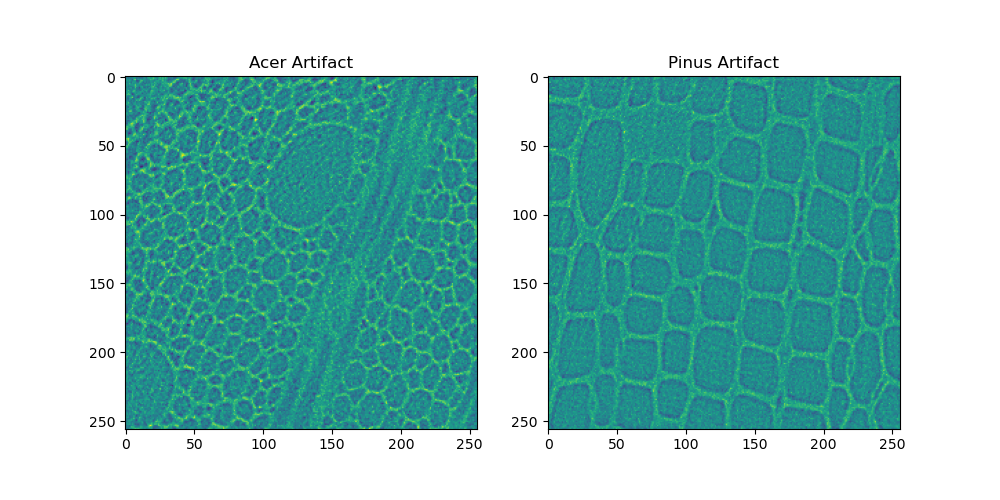

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes = axes.flat
vmin = -3.0
vmax = +3.0
kwargs = {'vmin' : vmin, 'vmax' : vmax}

ax = axes[0]
ax.set_title('Acer Artifact')
ax.imshow(acer_tensor.numpy()[0, 0, 128, ...], **kwargs)

ax = axes[1]
ax.set_title('Pinus Artifact')
ax.imshow(pinus_tensor.numpy()[0, 0, 128, ...], **kwargs)